Autograd backpropagation

In [5]:
import torch
from torchvision.models import resnet18, ResNet18_Weights

In [6]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# data is 1 image, 64x64, [R,G,B] ( nSamples x nChannels x Height x Width)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [7]:
prediction=model(data) # forward pass

In [10]:
loss = (prediction - labels).sum()
loss.backward() # backward pass - autograd auto calculates and stores gradients in parameters.grad

In [12]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2,momentum=0.9)

gradient descent calculation

In [13]:
optim.step()

differentiation in autograd
requires_grad tracks every operation

In [19]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

In [20]:
Q = 3*a**3 - b**2

In [21]:
print(a.grad)
print(b.grad)

None
None


Assume a and b are parameters of the Neural Network. Q is the error (loss). In SGD, we want to optimize the weights to minimize the loss loss. How does the loss change when changing the weight? The derivative tells us this.
We want to calculate the gradients (derivatives) of the error with respect to the parameters.
Parameters a & b partial derivatives (gradient fxns):
dQ/da = 9a^2
dQ/db = -2b

In [26]:
external_grad = torch.tensor([1., 1.])
Q.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

now, we have the gradient fxns associated to each parameter.

In [29]:
print(a.grad)
print(b.grad)

tensor([36., 81.])
tensor([-12.,  -8.])


In [31]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)
print(9*a**2)

tensor([True, True])
tensor([True, True])
tensor([36., 81.], grad_fn=<MulBackward0>)


## Neural Networks

define NN

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# nn.Module is the neural network module.
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


forward and backward function are defined. backward fxn is defined using autograd.

In [65]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


random 32x32 input -> expected size of this net.

In [66]:
input = torch.randn(1,1,32,32)
out = net(input)
print(out)

tensor([[ 0.1283, -0.0019, -0.0303, -0.1288,  0.0373, -0.1007, -0.0594, -0.0157,
         -0.1889,  0.0625]], grad_fn=<AddmmBackward0>)


In [68]:
net.zero_grad()
out.backward(torch.randn(1,10))

example of loss function with MSE.loss

In [71]:
output = net(input)
target = torch.randn(10) # dummy target
target = target.view(1,-1) # same shape as output
criterion = nn.MSELoss()

In [76]:
loss = criterion(target,output)

In [81]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])

None


need to clear the gradients

In [83]:
net.zero_grad()
loss.backward()
net.conv1.bias.grad

tensor([0., 0., 0., 0., 0., 0.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# Training an Image Classifier

Load and normalize CIFAR10 image dataset

In [84]:
import torchvision
import torchvision.transforms as transforms

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
# torchvision datasets are PILImages of range[0,1]. Transform to Tensors of normalized range [-1,1]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


show some training images

/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

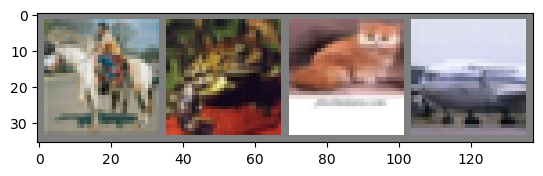

horse frog  cat   plane


In [86]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define CNN
very similar to the one above; however, we now have 3-channel images

In [87]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #  super(Net, self).__init__()
        # # 1 input image channel, 6 output channels, 5x5 square convolution
        # # kernel
        # self.conv1 = nn.Conv2d(1, 6, 5)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # # an affine operation: y = Wx + b
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Define a Loss fxn and optimizer

In [88]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train

In [89]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

[1,  2000] loss: 2.178
[1,  4000] loss: 1.842
[1,  6000] loss: 1.656
[1,  8000] loss: 1.588
[1, 10000] loss: 1.509
[1, 12000] loss: 1.485


/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

[2,  2000] loss: 1.399
[2,  4000] loss: 1.369
[2,  6000] loss: 1.372
[2,  8000] loss: 1.349
[2, 10000] loss: 1.311
[2, 12000] loss: 1.299
Finished Training


Save trained model

In [91]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test

/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

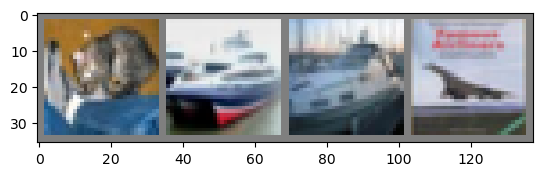

GroundTruth:  cat   ship  ship  plane


In [92]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Load saved model and make predictions

In [93]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Model predictions of the above images

In [95]:
outputs = net(images)

In [96]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   ship  ship 


accuracy of the whole dataset

In [97]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')



/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

Accuracy of the network on the 10000 test images: 54 %


better than 10% which is the probability of randomly guessing 1 of the 10 classes

accuracy of each class:

In [98]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so'
  Expected in: '/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/nate/mambaforge/envs/FastAI/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4ca

Accuracy for class: plane is 61.1 %
Accuracy for class: car   is 84.1 %
Accuracy for class: bird  is 33.2 %
Accuracy for class: cat   is 12.9 %
Accuracy for class: deer  is 62.7 %
Accuracy for class: dog   is 58.1 %
Accuracy for class: frog  is 70.6 %
Accuracy for class: horse is 54.2 %
Accuracy for class: ship  is 67.3 %
Accuracy for class: truck is 40.8 %


pytorch tensors can be transferred to GPU
same can be done with NN.

In [99]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu
